In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import stable_baselines3 as sb3
import stable_baselines3.common.logger as logger
import stable_baselines3.common.callbacks as callbacks
import stable_baselines3.common.env_checker as env_checker
from tqdm import tqdm, trange

import flygym.util.vision as vision
from flygym.envs.nmf_mujoco import MuJoCoParameters

import numpy as np
import gymnasium as gym
from typing import Tuple
from dm_control import mjcf
from dm_control.rl.control import PhysicsError

import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.envs.nmf_mujoco import MuJoCoParameters

from cpg_controller import NMFCPG

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [2]:
class MovingObjArena(BaseArena):
    """Flat terrain with a hovering moving object.

    Attributes
    ----------
    arena : mjcf.RootElement
        The arena object that the terrain is built on.
    ball_pos : Tuple[float,float,float]
        The position of the floating object in the arena.

    Parameters
    ----------
    size : Tuple[int, int]
        The size of the terrain in (x, y) dimensions.
    friction : Tuple[float, float, float]
        Sliding, torsional, and rolling friction coefficients, by default
        (1, 0.005, 0.0001)
    obj_radius : float
        Radius of the spherical floating object in mm.
    obj_spawn_pos : Tuple[float,float,float]
        Initial position of the object, by default (0, 2, 1).
    move_mode : string
        Type of movement performed by the floating object.
        Can be "random" (default value), "straightHeading", "circling" or "s_shape".
    move_speed : float
        Speed of the moving object. Angular velocity if move_mode=="circling" or "s_shape".
    """

    def __init__(
        self,
        size: Tuple[float, float] = (200, 200),
        friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
        obj_radius: float = 2,
        init_ball_pos: Tuple[float, float, float] = (5, 0),
        move_speed: float = 25,
        move_direction: str = "random",
    ):
        self.init_ball_pos = (*init_ball_pos, obj_radius)
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        self.friction = friction
        self.move_speed = move_speed
        self.curr_time = 0
        self.move_direction = move_direction
        if move_direction == "left":
            self.y_mult = 1
        elif move_direction == "right":
            self.y_mult = -1
        elif move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        else:
            raise ValueError("Invalid move_direction")

        self.root_element = mjcf.RootElement()

        # Add ground
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(10, 10),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")

        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=self.ball_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )

        # Add camera
        self.root_element.worldbody.add(
            "camera",
            name="birdseye_cam",
            mode="fixed",
            pos=(0, 0, 50),
            euler=(0, 0, 0),
            fovy=40,
        )

    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return rel_pos, rel_angle

    def step(self, dt, physics):
        heading_vec = np.array([1, 0.5 * np.cos(self.curr_time * 3) * self.y_mult])
        heading_vec /= np.linalg.norm(heading_vec)
        self.ball_pos[:2] += self.move_speed * heading_vec * dt
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self.curr_time += dt

    def reset(self, physics):
        if self.move_direction == "random":
            self.y_mult = np.random.choice([-1, 1])
        self.curr_time = 0
        self.ball_pos = np.array(self.init_ball_pos, dtype="float32")
        physics.bind(self.object_body).mocap_pos = self.ball_pos


class NMFVisualTaxis(NMFCPG):
    def __init__(
        self,
        decision_dt=0.05,
        n_stabilisation_steps: int = 5000,
        obj_threshold=50,
        max_time=2,
        **kwargs
    ) -> None:
        if "sim_params" in kwargs:
            sim_params = kwargs["sim_params"]
            del kwargs["sim_params"]
        else:
            sim_params = MuJoCoParameters()
        sim_params.enable_vision = True
        sim_params.vision_refresh_rate = int(1 / decision_dt)
        self.max_time = max_time

        super().__init__(
            sim_params=sim_params,
            n_oscillators=6,
            n_stabilisation_steps=n_stabilisation_steps,
            **kwargs
        )
        self.decision_dt = decision_dt
        self.obj_threshold = obj_threshold
        self.num_substeps = int(decision_dt / self.timestep)

        # Override spaces
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(6,))

        # Compute x-y position of each ommatidium
        self.coms = np.empty((config.num_ommatidia_per_eye, 2))
        for i in range(config.num_ommatidia_per_eye):
            mask = vision.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

        # self._last_offset_from_ideal = self._calc_offset_from_ideal(
        #     np.zeros(2), self.arena.ball_pos[:2]
        # )
        self._last_fly_tgt_dist = np.linalg.norm(
            np.zeros(2) - (self.arena.ball_pos[:2] - np.array([5, 0]))
        )

    @staticmethod
    def _calc_offset_from_ideal(fly_pos, obj_pos):
        fly_obj_distance = np.linalg.norm(fly_pos - obj_pos)
        return np.abs(fly_obj_distance - 5)

    def step(self, amplitude):
        try:
            for i in range(self.num_substeps):
                raw_obs, _, raw_term, raw_trunc, info = super().step(amplitude)
                super().render()
        except PhysicsError:
            print("Physics error, resetting environment")
            return np.zeros((6,), dtype="float32"), 0, False, True, {}

        assert abs(self.curr_time - self._last_vision_update_time) < 0.5 * self.timestep
        obs = self._get_visual_features().astype("float32")

        # calculate reward
        fly_pos = super().get_observation()["fly"][0, :2]
        obj_pos = self.arena.ball_pos[:2]
        tgt_pos = obj_pos - np.array([5, 0])
        fly_obj_dist = np.linalg.norm(fly_pos - obj_pos)
        fly_tgt_dist = np.linalg.norm(fly_pos - tgt_pos)
        unadjusted_reward = self._last_fly_tgt_dist - fly_tgt_dist
        if obs[2] + obs[5] < 0.005:  # lost object from both eyes, fail
            reward = -15
            terminated = True
            info["state_desc"] = "object lost visually"
        elif fly_tgt_dist > 15:  # too far from object, fail
            reward = -15
            terminated = True
            info["state_desc"] = "too far from object"
        elif fly_obj_dist < 3:  # too close/collision, fail
            reward = -5
            terminated = True
            info["state_desc"] = "collision with object"
        elif fly_tgt_dist < 1:  # ideal range
            reward = 3
            terminated = False
            info["state_desc"] = "ideal range"
        else:
            reward = unadjusted_reward
            terminated = False
            info["state_desc"] = "seeking"
        info["unadjusted_reward"] = unadjusted_reward
        info["fly_obj_dist"] = fly_obj_dist
        info["fly_tgt_dist"] = fly_tgt_dist
        truncated = self.curr_time > 1 and not terminated  # start a new episode
        self._last_fly_tgt_dist = fly_tgt_dist

        return obs, reward, terminated, truncated, info

    def reset(self):
        super().reset()
        self.arena.reset(self.physics)
        obs = self._get_visual_features().astype("float32")
        self._last_fly_tgt_dist = np.linalg.norm(
            np.zeros(2) - (self.arena.ball_pos[:2] - np.array([5, 0]))
        )
        return obs, {}

    def _get_visual_features(self):
        raw_obs = super().get_observation()
        # features = np.full((2, 3), np.nan)  # ({L, R}, {y_center, x_center, area})
        features = np.zeros((2, 3))
        for i, ommatidia_readings in enumerate(raw_obs["vision"]):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj[
                np.arange(is_obj.size) % 2 == 1
            ] = False  # only use pale-type ommatidia
            is_obj_coords = self.coms[is_obj]
            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
            features[i, 2] = is_obj_coords.shape[0]
        features[:, 0] /= config.raw_img_height_px  # normalize y_center
        features[:, 1] /= config.raw_img_width_px  # normalize x_center
        # features[:, :2] = features[:, :2] * 2 - 1  # center around 0
        features[:, 2] /= config.num_ommatidia_per_eye  # normalize area
        return features.flatten()

In [3]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

In [4]:
arena = MovingObjArena(init_ball_pos=(5, 0), move_speed=40)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
sim = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)

obs, info = sim.reset()

for i in range(10):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    print(reward, terminated, truncated, info)

sim.reset()

obs_hist = [obs]
visual_hist = [sim.curr_visual_input]
ball_pos_hist = []
for i in range(30):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    obs_hist.append(obs)
    ball_pos_hist.append(sim.arena.ball_pos[:2])
    if i < 9:
        visual_hist.append(sim.curr_visual_input)
    print(reward, terminated, truncated, info)

sim.save_video("visual_taxis_test2.mp4")

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


-1.160158800825252 False False {'state_desc': 'seeking', 'unadjusted_reward': -1.160158800825252, 'fly_obj_dist': 5.748696756597869, 'fly_tgt_dist': 1.160158800825252}
-0.8244515803580525 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.8244515803580525, 'fly_obj_dist': 5.833879870091854, 'fly_tgt_dist': 1.9846103811833045}
-0.9113643686137052 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.9113643686137052, 'fly_obj_dist': 6.281877737927746, 'fly_tgt_dist': 2.8959747497970096}
-0.858351885288994 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.858351885288994, 'fly_obj_dist': 6.843761873830581, 'fly_tgt_dist': 3.7543266350860036}
-0.7827954829775448 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.7827954829775448, 'fly_obj_dist': 7.452485997999416, 'fly_tgt_dist': 4.537122118063548}
-0.6256272210393377 False False {'state_desc': 'seeking', 'unadjusted_reward': -0.6256272210393377, 'fly_obj_dist': 7.978412974505936, 'fly_tgt_dist': 

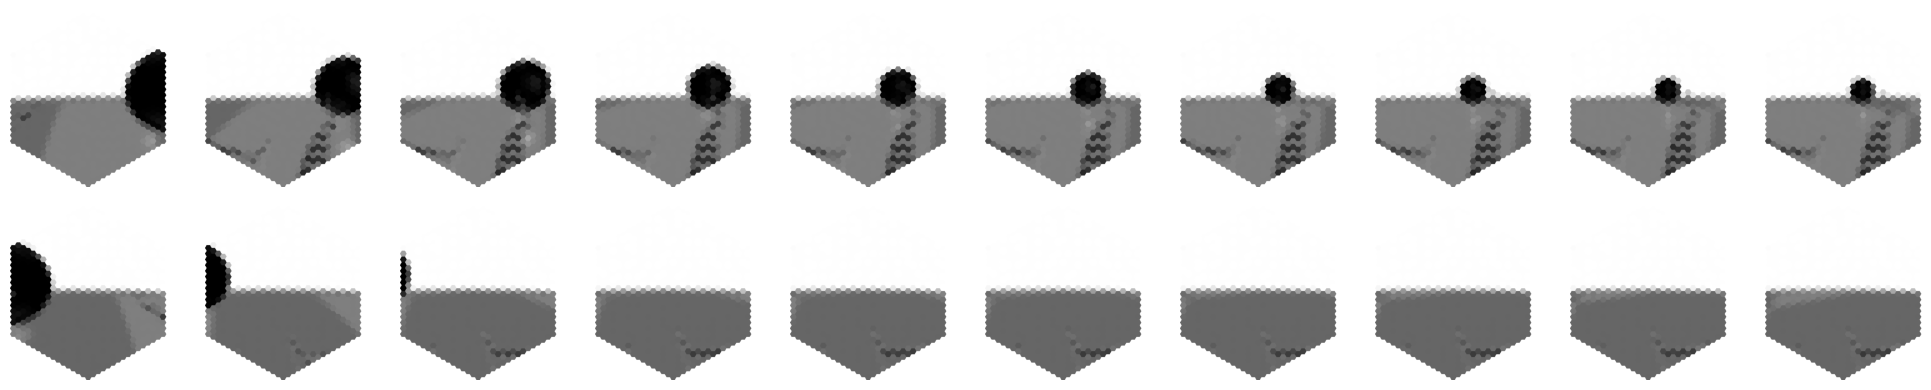

In [5]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4), tight_layout=True)
for i, visual_obs in enumerate(visual_hist):
    human_readable_img_left = vision.hex_pxls_to_human_readable(visual_obs[0], vision.ommatidia_id_map)
    axs[0, i].imshow(human_readable_img_left, cmap="gray", vmin=0, vmax=255)
    axs[0, i].axis("off")
    human_readable_img_right = vision.hex_pxls_to_human_readable(visual_obs[1], vision.ommatidia_id_map)
    axs[1, i].imshow(human_readable_img_right, cmap="gray", vmin=0, vmax=255)
    axs[1, i].axis("off")

(-0.01, 0.3)

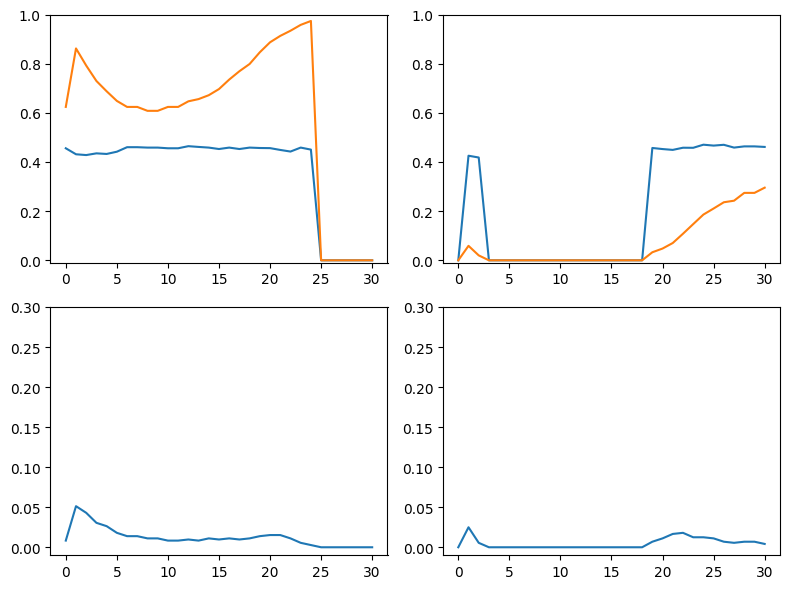

In [6]:
obs_hist = np.array(obs_hist)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 0].set_ylim(-0.01, 1)
axs[1, 0].plot(obs_hist[:, 2])
axs[1, 0].set_ylim(-0.01, 0.3)

axs[0, 1].plot(obs_hist[:, 3])
axs[0, 1].plot(obs_hist[:, 4])
axs[0, 1].set_ylim(-0.01, 1)
axs[1, 1].plot(obs_hist[:, 5])
axs[1, 1].set_ylim(-0.01, 0.3)

In [9]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

arena = MovingObjArena(init_ball_pos=(5, 0), move_speed=45)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
task = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)
env_checker.check_env(task)

start_from = None
train = True

log_dir = "logs/object_tracking_sac_const_speed"
checkpoint_callback = callbacks.CheckpointCallback(
  save_freq=1000,
  save_path=log_dir,
  name_prefix="object_tracking_sac_const_speed",
  save_replay_buffer=True,
  save_vecnormalize=True,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC("MlpPolicy", env=task, policy_kwargs={"net_arch": [16, 16]}, verbose=2, learning_rate=0.01)
if start_from is not None:
    model = sb3.SAC.load(start_from)
model.set_logger(my_logger)

if train:
    model.learn(total_timesteps=10_000, progress_bar=True, callback=checkpoint_callback)
    model.save("models/object_tracking_sac_const_speed")

Logging to logs/object_tracking_sac_const_speed
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.75     |
|    ep_rew_mean     | -23.8    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 29       |
|    total_timesteps | 31       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.12     |
|    ep_rew_mean     | -24.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1        |
|    time_elapsed    | 62       |
|    total_timesteps | 65       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -24.1    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1        |
|    time_elapsed    | 91       |
|    total_timesteps | 96       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.81     |
|    ep_rew_mean     | -24      |
| time/              |          |
|    episodes        | 16       |
|    fps             | 1        |
|    time_elapsed    | 119      |
|    total_timesteps | 125      |
| train/             |          |
|    actor_loss      | 1.51     |
|    critic_loss     | 24.1     |
|    ent_coef        | 0.794    |
|    ent_coef_loss   | -0.772   |
|    learning_rate   | 0.01     |
|    n_updates       | 24       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.05     |
|    ep_rew_mean     | -23.9    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 1        |
|    time_elapsed    | 151      |
|    total_timesteps | 161      |
| train/             |          |
|    actor_loss      | 1.7      |
|    critic_loss     | 21.4     |
|    ent_coef        | 0.56     |
|    ent_coef_loss   | -1.81    |
|    learning_rate   | 0.01     |
|    n_updates       | 60       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.75     |
|    ep_rew_mean     | -23.4    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 1        |
|    time_elapsed    | 195      |
|    total_timesteps | 210      |
| train/             |          |
|    actor_loss      | 2.51     |
|    critic_loss     | 15.6     |
|    ent_coef        | 0.355    |
|    ent_coef_loss   | -2.49    |
|    learning_rate   | 0.01     |
|    n_updates       | 109      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.32     |
|    ep_rew_mean     | -22.8    |
| time/              |          |
|    episodes        | 28       |
|    fps             | 1        |
|    time_elapsed    | 242      |
|    total_timesteps | 261      |
| train/             |          |
|    actor_loss      | 2.66     |
|    critic_loss     | 10.8     |
|    ent_coef        | 0.228    |
|    ent_coef_loss   | -3.39    |
|    learning_rate   | 0.01     |
|    n_updates       | 160      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.5      |
|    ep_rew_mean     | -22.2    |
| time/              |          |
|    episodes        | 32       |
|    fps             | 1        |
|    time_elapsed    | 282      |
|    total_timesteps | 304      |
| train/             |          |
|    actor_loss      | 3.02     |
|    critic_loss     | 10.3     |
|    ent_coef        | 0.165    |
|    ent_coef_loss   | -2.63    |
|    learning_rate   | 0.01     |
|    n_updates       | 203      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.64     |
|    ep_rew_mean     | -22.5    |
| time/              |          |
|    episodes        | 36       |
|    fps             | 1        |
|    time_elapsed    | 324      |
|    total_timesteps | 347      |
| train/             |          |
|    actor_loss      | 3.46     |
|    critic_loss     | 7.84     |
|    ent_coef        | 0.127    |
|    ent_coef_loss   | -3.34    |
|    learning_rate   | 0.01     |
|    n_updates       | 246      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.97     |
|    ep_rew_mean     | -22.1    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 1        |
|    time_elapsed    | 372      |
|    total_timesteps | 399      |
| train/             |          |
|    actor_loss      | 3.58     |
|    critic_loss     | 11.3     |
|    ent_coef        | 0.0994   |
|    ent_coef_loss   | -3.91    |
|    learning_rate   | 0.01     |
|    n_updates       | 298      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.4     |
|    ep_rew_mean     | -21.7    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 1        |
|    time_elapsed    | 425      |
|    total_timesteps | 459      |
| train/             |          |
|    actor_loss      | 3.95     |
|    critic_loss     | 8.34     |
|    ent_coef        | 0.0769   |
|    ent_coef_loss   | -0.195   |
|    learning_rate   | 0.01     |
|    n_updates       | 358      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.8     |
|    ep_rew_mean     | -21.4    |
| time/              |          |
|    episodes        | 48       |
|    fps             | 1        |
|    time_elapsed    | 477      |
|    total_timesteps | 517      |
| train/             |          |
|    actor_loss      | 4.16     |
|    critic_loss     | 6.78     |
|    ent_coef        | 0.0627   |
|    ent_coef_loss   | -1.11    |
|    learning_rate   | 0.01     |
|    n_updates       | 416      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.3     |
|    ep_rew_mean     | -21.1    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 1        |
|    time_elapsed    | 539      |
|    total_timesteps | 590      |
| train/             |          |
|    actor_loss      | 4.7      |
|    critic_loss     | 5.07     |
|    ent_coef        | 0.0592   |
|    ent_coef_loss   | 1.6      |
|    learning_rate   | 0.01     |
|    n_updates       | 489      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.6     |
|    ep_rew_mean     | -21      |
| time/              |          |
|    episodes        | 56       |
|    fps             | 1        |
|    time_elapsed    | 592      |
|    total_timesteps | 648      |
| train/             |          |
|    actor_loss      | 5.1      |
|    critic_loss     | 4.31     |
|    ent_coef        | 0.0616   |
|    ent_coef_loss   | 0.965    |
|    learning_rate   | 0.01     |
|    n_updates       | 547      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.7     |
|    ep_rew_mean     | -20.8    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 1        |
|    time_elapsed    | 641      |
|    total_timesteps | 701      |
| train/             |          |
|    actor_loss      | 4.84     |
|    critic_loss     | 3.55     |
|    ent_coef        | 0.0671   |
|    ent_coef_loss   | 1.17     |
|    learning_rate   | 0.01     |
|    n_updates       | 600      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.6     |
|    ep_rew_mean     | -21      |
| time/              |          |
|    episodes        | 64       |
|    fps             | 1        |
|    time_elapsed    | 681      |
|    total_timesteps | 743      |
| train/             |          |
|    actor_loss      | 5.48     |
|    critic_loss     | 3.96     |
|    ent_coef        | 0.0696   |
|    ent_coef_loss   | -0.801   |
|    learning_rate   | 0.01     |
|    n_updates       | 642      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.8     |
|    ep_rew_mean     | -21.1    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 1        |
|    time_elapsed    | 736      |
|    total_timesteps | 800      |
| train/             |          |
|    actor_loss      | 6.01     |
|    critic_loss     | 3.24     |
|    ent_coef        | 0.0703   |
|    ent_coef_loss   | 0.199    |
|    learning_rate   | 0.01     |
|    n_updates       | 699      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.2     |
|    ep_rew_mean     | -20.6    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 1        |
|    time_elapsed    | 807      |
|    total_timesteps | 876      |
| train/             |          |
|    actor_loss      | 6.07     |
|    critic_loss     | 2.58     |
|    ent_coef        | 0.0684   |
|    ent_coef_loss   | 0.452    |
|    learning_rate   | 0.01     |
|    n_updates       | 775      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.6     |
|    ep_rew_mean     | -19.8    |
| time/              |          |
|    episodes        | 76       |
|    fps             | 1        |
|    time_elapsed    | 884      |
|    total_timesteps | 959      |
| train/             |          |
|    actor_loss      | 6.61     |
|    critic_loss     | 2.67     |
|    ent_coef        | 0.0652   |
|    ent_coef_loss   | 0.285    |
|    learning_rate   | 0.01     |
|    n_updates       | 858      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.8     |
|    ep_rew_mean     | -19.7    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 1        |
|    time_elapsed    | 937      |
|    total_timesteps | 1020     |
| train/             |          |
|    actor_loss      | 6.8      |
|    critic_loss     | 1.53     |
|    ent_coef        | 0.0657   |
|    ent_coef_loss   | -0.107   |
|    learning_rate   | 0.01     |
|    n_updates       | 919      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.6     |
|    ep_rew_mean     | -19.9    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 1        |
|    time_elapsed    | 973      |
|    total_timesteps | 1061     |
| train/             |          |
|    actor_loss      | 6.93     |
|    critic_loss     | 2.26     |
|    ent_coef        | 0.068    |
|    ent_coef_loss   | -0.668   |
|    learning_rate   | 0.01     |
|    n_updates       | 960      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.7     |
|    ep_rew_mean     | -19.8    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 1        |
|    time_elapsed    | 1025     |
|    total_timesteps | 1121     |
| train/             |          |
|    actor_loss      | 7.4      |
|    critic_loss     | 1.88     |
|    ent_coef        | 0.0655   |
|    ent_coef_loss   | 1.12     |
|    learning_rate   | 0.01     |
|    n_updates       | 1020     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.8     |
|    ep_rew_mean     | -20      |
| time/              |          |
|    episodes        | 92       |
|    fps             | 1        |
|    time_elapsed    | 1071     |
|    total_timesteps | 1174     |
| train/             |          |
|    actor_loss      | 8.1      |
|    critic_loss     | 2.28     |
|    ent_coef        | 0.068    |
|    ent_coef_loss   | 0.453    |
|    learning_rate   | 0.01     |
|    n_updates       | 1073     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.9     |
|    ep_rew_mean     | -19.9    |
| time/              |          |
|    episodes        | 96       |
|    fps             | 1        |
|    time_elapsed    | 1131     |
|    total_timesteps | 1243     |
| train/             |          |
|    actor_loss      | 8.17     |
|    critic_loss     | 1.15     |
|    ent_coef        | 0.0636   |
|    ent_coef_loss   | -0.0312  |
|    learning_rate   | 0.01     |
|    n_updates       | 1142     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | -19.4    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 1        |
|    time_elapsed    | 1204     |
|    total_timesteps | 1326     |
| train/             |          |
|    actor_loss      | 8.88     |
|    critic_loss     | 1.87     |
|    ent_coef        | 0.0578   |
|    ent_coef_loss   | -0.458   |
|    learning_rate   | 0.01     |
|    n_updates       | 1225     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | -19.2    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 1        |
|    time_elapsed    | 1273     |
|    total_timesteps | 1402     |
| train/             |          |
|    actor_loss      | 8.45     |
|    critic_loss     | 1.1      |
|    ent_coef        | 0.0555   |
|    ent_coef_loss   | -0.0885  |
|    learning_rate   | 0.01     |
|    n_updates       | 1301     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.1     |
|    ep_rew_mean     | -18.6    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 1        |
|    time_elapsed    | 1343     |
|    total_timesteps | 1478     |
| train/             |          |
|    actor_loss      | 9.45     |
|    critic_loss     | 1.05     |
|    ent_coef        | 0.0535   |
|    ent_coef_loss   | -0.0523  |
|    learning_rate   | 0.01     |
|    n_updates       | 1377     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.5     |
|    ep_rew_mean     | -18.5    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 1        |
|    time_elapsed    | 1401     |
|    total_timesteps | 1542     |
| train/             |          |
|    actor_loss      | 9.34     |
|    critic_loss     | 1.52     |
|    ent_coef        | 0.0476   |
|    ent_coef_loss   | -0.28    |
|    learning_rate   | 0.01     |
|    n_updates       | 1441     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.9     |
|    ep_rew_mean     | -18.1    |
| time/              |          |
|    episodes        | 116      |
|    fps             | 1        |
|    time_elapsed    | 1466     |
|    total_timesteps | 1616     |
| train/             |          |
|    actor_loss      | 9.68     |
|    critic_loss     | 1.44     |
|    ent_coef        | 0.0425   |
|    ent_coef_loss   | -0.669   |
|    learning_rate   | 0.01     |
|    n_updates       | 1515     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | -17.8    |
| time/              |          |
|    episodes        | 120      |
|    fps             | 1        |
|    time_elapsed    | 1519     |
|    total_timesteps | 1675     |
| train/             |          |
|    actor_loss      | 9.93     |
|    critic_loss     | 1.6      |
|    ent_coef        | 0.0418   |
|    ent_coef_loss   | 1.84     |
|    learning_rate   | 0.01     |
|    n_updates       | 1574     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | -17.7    |
| time/              |          |
|    episodes        | 124      |
|    fps             | 1        |
|    time_elapsed    | 1564     |
|    total_timesteps | 1723     |
| train/             |          |
|    actor_loss      | 10.2     |
|    critic_loss     | 2.51     |
|    ent_coef        | 0.0429   |
|    ent_coef_loss   | 0.262    |
|    learning_rate   | 0.01     |
|    n_updates       | 1622     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.1     |
|    ep_rew_mean     | -17.7    |
| time/              |          |
|    episodes        | 128      |
|    fps             | 1        |
|    time_elapsed    | 1613     |
|    total_timesteps | 1773     |
| train/             |          |
|    actor_loss      | 9.93     |
|    critic_loss     | 2.01     |
|    ent_coef        | 0.0437   |
|    ent_coef_loss   | -1.67    |
|    learning_rate   | 0.01     |
|    n_updates       | 1672     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.3     |
|    ep_rew_mean     | -17.6    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 1        |
|    time_elapsed    | 1673     |
|    total_timesteps | 1837     |
| train/             |          |
|    actor_loss      | 10.3     |
|    critic_loss     | 2.34     |
|    ent_coef        | 0.0384   |
|    ent_coef_loss   | 0.0291   |
|    learning_rate   | 0.01     |
|    n_updates       | 1736     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.6     |
|    ep_rew_mean     | -17.2    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 1        |
|    time_elapsed    | 1740     |
|    total_timesteps | 1908     |
| train/             |          |
|    actor_loss      | 10.5     |
|    critic_loss     | 1.96     |
|    ent_coef        | 0.0364   |
|    ent_coef_loss   | -1.28    |
|    learning_rate   | 0.01     |
|    n_updates       | 1807     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.8     |
|    ep_rew_mean     | -17      |
| time/              |          |
|    episodes        | 140      |
|    fps             | 1        |
|    time_elapsed    | 1806     |
|    total_timesteps | 1979     |
| train/             |          |
|    actor_loss      | 11.2     |
|    critic_loss     | 2.69     |
|    ent_coef        | 0.0352   |
|    ent_coef_loss   | -0.554   |
|    learning_rate   | 0.01     |
|    n_updates       | 1878     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.9     |
|    ep_rew_mean     | -16.7    |
| time/              |          |
|    episodes        | 144      |
|    fps             | 1        |
|    time_elapsed    | 1874     |
|    total_timesteps | 2052     |
| train/             |          |
|    actor_loss      | 11.4     |
|    critic_loss     | 2.23     |
|    ent_coef        | 0.0344   |
|    ent_coef_loss   | -0.926   |
|    learning_rate   | 0.01     |
|    n_updates       | 1951     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.2     |
|    ep_rew_mean     | -16.4    |
| time/              |          |
|    episodes        | 148      |
|    fps             | 1        |
|    time_elapsed    | 1948     |
|    total_timesteps | 2135     |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 2.55     |
|    ent_coef        | 0.0328   |
|    ent_coef_loss   | -1.09    |
|    learning_rate   | 0.01     |
|    n_updates       | 2034     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.3     |
|    ep_rew_mean     | -16.3    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 1        |
|    time_elapsed    | 2019     |
|    total_timesteps | 2216     |
| train/             |          |
|    actor_loss      | 12.2     |
|    critic_loss     | 2.52     |
|    ent_coef        | 0.0298   |
|    ent_coef_loss   | 1.47     |
|    learning_rate   | 0.01     |
|    n_updates       | 2115     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.5     |
|    ep_rew_mean     | -15.7    |
| time/              |          |
|    episodes        | 156      |
|    fps             | 1        |
|    time_elapsed    | 2092     |
|    total_timesteps | 2300     |
| train/             |          |
|    actor_loss      | 12.2     |
|    critic_loss     | 2.46     |
|    ent_coef        | 0.0294   |
|    ent_coef_loss   | 1.18     |
|    learning_rate   | 0.01     |
|    n_updates       | 2199     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 1        |
|    time_elapsed    | 2160     |
|    total_timesteps | 2381     |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 2.51     |
|    ent_coef        | 0.028    |
|    ent_coef_loss   | 3.77     |
|    learning_rate   | 0.01     |
|    n_updates       | 2280     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | -14.8    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 1        |
|    time_elapsed    | 2226     |
|    total_timesteps | 2455     |
| train/             |          |
|    actor_loss      | 12.4     |
|    critic_loss     | 3.25     |
|    ent_coef        | 0.034    |
|    ent_coef_loss   | -2.43    |
|    learning_rate   | 0.01     |
|    n_updates       | 2354     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 168      |
|    fps             | 1        |
|    time_elapsed    | 2283     |
|    total_timesteps | 2520     |
| train/             |          |
|    actor_loss      | 12.7     |
|    critic_loss     | 2.03     |
|    ent_coef        | 0.029    |
|    ent_coef_loss   | -0.0837  |
|    learning_rate   | 0.01     |
|    n_updates       | 2419     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -14.2    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 1        |
|    time_elapsed    | 2359     |
|    total_timesteps | 2602     |
| train/             |          |
|    actor_loss      | 13.1     |
|    critic_loss     | 3.95     |
|    ent_coef        | 0.0271   |
|    ent_coef_loss   | -0.418   |
|    learning_rate   | 0.01     |
|    n_updates       | 2501     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 1        |
|    time_elapsed    | 2429     |
|    total_timesteps | 2678     |
| train/             |          |
|    actor_loss      | 12.8     |
|    critic_loss     | 3.91     |
|    ent_coef        | 0.0226   |
|    ent_coef_loss   | -0.491   |
|    learning_rate   | 0.01     |
|    n_updates       | 2577     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 180      |
|    fps             | 1        |
|    time_elapsed    | 2497     |
|    total_timesteps | 2754     |
| train/             |          |
|    actor_loss      | 13.2     |
|    critic_loss     | 3.88     |
|    ent_coef        | 0.0242   |
|    ent_coef_loss   | 0.523    |
|    learning_rate   | 0.01     |
|    n_updates       | 2653     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 184      |
|    fps             | 1        |
|    time_elapsed    | 2549     |
|    total_timesteps | 2809     |
| train/             |          |
|    actor_loss      | 13.3     |
|    critic_loss     | 3.4      |
|    ent_coef        | 0.0294   |
|    ent_coef_loss   | 0.735    |
|    learning_rate   | 0.01     |
|    n_updates       | 2708     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 188      |
|    fps             | 1        |
|    time_elapsed    | 2627     |
|    total_timesteps | 2893     |
| train/             |          |
|    actor_loss      | 13.3     |
|    critic_loss     | 2.83     |
|    ent_coef        | 0.0282   |
|    ent_coef_loss   | -1.05    |
|    learning_rate   | 0.01     |
|    n_updates       | 2792     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 192      |
|    fps             | 1        |
|    time_elapsed    | 2706     |
|    total_timesteps | 2977     |
| train/             |          |
|    actor_loss      | 12.9     |
|    critic_loss     | 2.9      |
|    ent_coef        | 0.0265   |
|    ent_coef_loss   | -0.258   |
|    learning_rate   | 0.01     |
|    n_updates       | 2876     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -11.9    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 1        |
|    time_elapsed    | 2769     |
|    total_timesteps | 3042     |
| train/             |          |
|    actor_loss      | 12.3     |
|    critic_loss     | 2.29     |
|    ent_coef        | 0.0274   |
|    ent_coef_loss   | 0.135    |
|    learning_rate   | 0.01     |
|    n_updates       | 2941     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 200      |
|    fps             | 1        |
|    time_elapsed    | 2826     |
|    total_timesteps | 3101     |
| train/             |          |
|    actor_loss      | 13.6     |
|    critic_loss     | 3.45     |
|    ent_coef        | 0.0261   |
|    ent_coef_loss   | 1.41     |
|    learning_rate   | 0.01     |
|    n_updates       | 3000     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 204      |
|    fps             | 1        |
|    time_elapsed    | 2877     |
|    total_timesteps | 3152     |
| train/             |          |
|    actor_loss      | 13.8     |
|    critic_loss     | 3.66     |
|    ent_coef        | 0.0281   |
|    ent_coef_loss   | 2.16     |
|    learning_rate   | 0.01     |
|    n_updates       | 3051     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 208      |
|    fps             | 1        |
|    time_elapsed    | 2922     |
|    total_timesteps | 3199     |
| train/             |          |
|    actor_loss      | 13.3     |
|    critic_loss     | 4.1      |
|    ent_coef        | 0.0251   |
|    ent_coef_loss   | 1.25     |
|    learning_rate   | 0.01     |
|    n_updates       | 3098     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.4     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 212      |
|    fps             | 1        |
|    time_elapsed    | 2999     |
|    total_timesteps | 3278     |
| train/             |          |
|    actor_loss      | 13.4     |
|    critic_loss     | 3.91     |
|    ent_coef        | 0.0239   |
|    ent_coef_loss   | -1.25    |
|    learning_rate   | 0.01     |
|    n_updates       | 3177     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -11.9    |
| time/              |          |
|    episodes        | 216      |
|    fps             | 1        |
|    time_elapsed    | 3067     |
|    total_timesteps | 3350     |
| train/             |          |
|    actor_loss      | 13.6     |
|    critic_loss     | 3.64     |
|    ent_coef        | 0.0222   |
|    ent_coef_loss   | 1.78     |
|    learning_rate   | 0.01     |
|    n_updates       | 3249     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 220      |
|    fps             | 1        |
|    time_elapsed    | 3109     |
|    total_timesteps | 3396     |
| train/             |          |
|    actor_loss      | 13.5     |
|    critic_loss     | 4.35     |
|    ent_coef        | 0.0247   |
|    ent_coef_loss   | 0.401    |
|    learning_rate   | 0.01     |
|    n_updates       | 3295     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -11.8    |
| time/              |          |
|    episodes        | 224      |
|    fps             | 1        |
|    time_elapsed    | 3160     |
|    total_timesteps | 3455     |
| train/             |          |
|    actor_loss      | 14.3     |
|    critic_loss     | 3.74     |
|    ent_coef        | 0.0236   |
|    ent_coef_loss   | 2.06     |
|    learning_rate   | 0.01     |
|    n_updates       | 3354     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -11.8    |
| time/              |          |
|    episodes        | 228      |
|    fps             | 1        |
|    time_elapsed    | 3202     |
|    total_timesteps | 3500     |
| train/             |          |
|    actor_loss      | 14.3     |
|    critic_loss     | 3.38     |
|    ent_coef        | 0.0217   |
|    ent_coef_loss   | -2.73    |
|    learning_rate   | 0.01     |
|    n_updates       | 3399     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -11.9    |
| time/              |          |
|    episodes        | 232      |
|    fps             | 1        |
|    time_elapsed    | 3256     |
|    total_timesteps | 3557     |
| train/             |          |
|    actor_loss      | 12.9     |
|    critic_loss     | 3.29     |
|    ent_coef        | 0.0151   |
|    ent_coef_loss   | 0.17     |
|    learning_rate   | 0.01     |
|    n_updates       | 3456     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.9     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 236      |
|    fps             | 1        |
|    time_elapsed    | 3298     |
|    total_timesteps | 3599     |
| train/             |          |
|    actor_loss      | 13.7     |
|    critic_loss     | 3.36     |
|    ent_coef        | 0.0159   |
|    ent_coef_loss   | 6.08     |
|    learning_rate   | 0.01     |
|    n_updates       | 3498     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 240      |
|    fps             | 1        |
|    time_elapsed    | 3358     |
|    total_timesteps | 3661     |
| train/             |          |
|    actor_loss      | 13.8     |
|    critic_loss     | 3.03     |
|    ent_coef        | 0.0206   |
|    ent_coef_loss   | -2.21    |
|    learning_rate   | 0.01     |
|    n_updates       | 3560     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.7     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 244      |
|    fps             | 1        |
|    time_elapsed    | 3416     |
|    total_timesteps | 3722     |
| train/             |          |
|    actor_loss      | 14.4     |
|    critic_loss     | 3.15     |
|    ent_coef        | 0.0177   |
|    ent_coef_loss   | -0.317   |
|    learning_rate   | 0.01     |
|    n_updates       | 3621     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.4     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 248      |
|    fps             | 1        |
|    time_elapsed    | 3464     |
|    total_timesteps | 3770     |
| train/             |          |
|    actor_loss      | 14.5     |
|    critic_loss     | 3.42     |
|    ent_coef        | 0.0146   |
|    ent_coef_loss   | -0.937   |
|    learning_rate   | 0.01     |
|    n_updates       | 3669     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.3     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 252      |
|    fps             | 1        |
|    time_elapsed    | 3534     |
|    total_timesteps | 3843     |
| train/             |          |
|    actor_loss      | 14.2     |
|    critic_loss     | 3.59     |
|    ent_coef        | 0.0162   |
|    ent_coef_loss   | -1.34    |
|    learning_rate   | 0.01     |
|    n_updates       | 3742     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.1     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 256      |
|    fps             | 1        |
|    time_elapsed    | 3598     |
|    total_timesteps | 3906     |
| train/             |          |
|    actor_loss      | 14.5     |
|    critic_loss     | 3.68     |
|    ent_coef        | 0.0198   |
|    ent_coef_loss   | -1.02    |
|    learning_rate   | 0.01     |
|    n_updates       | 3805     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.1     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 260      |
|    fps             | 1        |
|    time_elapsed    | 3679     |
|    total_timesteps | 3990     |
| train/             |          |
|    actor_loss      | 14.6     |
|    critic_loss     | 3.47     |
|    ent_coef        | 0.0179   |
|    ent_coef_loss   | 0.854    |
|    learning_rate   | 0.01     |
|    n_updates       | 3889     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.2     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 264      |
|    fps             | 1        |
|    time_elapsed    | 3760     |
|    total_timesteps | 4074     |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 2.96     |
|    ent_coef        | 0.0146   |
|    ent_coef_loss   | -1.55    |
|    learning_rate   | 0.01     |
|    n_updates       | 3973     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.3     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 268      |
|    fps             | 1        |
|    time_elapsed    | 3834     |
|    total_timesteps | 4153     |
| train/             |          |
|    actor_loss      | 14.1     |
|    critic_loss     | 4.71     |
|    ent_coef        | 0.0146   |
|    ent_coef_loss   | 2        |
|    learning_rate   | 0.01     |
|    n_updates       | 4052     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.1     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 272      |
|    fps             | 1        |
|    time_elapsed    | 3894     |
|    total_timesteps | 4215     |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 3.33     |
|    ent_coef        | 0.0181   |
|    ent_coef_loss   | 1.23     |
|    learning_rate   | 0.01     |
|    n_updates       | 4114     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16       |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 276      |
|    fps             | 1        |
|    time_elapsed    | 3952     |
|    total_timesteps | 4280     |
| train/             |          |
|    actor_loss      | 14.8     |
|    critic_loss     | 4.25     |
|    ent_coef        | 0.0196   |
|    ent_coef_loss   | -0.998   |
|    learning_rate   | 0.01     |
|    n_updates       | 4179     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.9     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 280      |
|    fps             | 1        |
|    time_elapsed    | 4010     |
|    total_timesteps | 4348     |
| train/             |          |
|    actor_loss      | 14.5     |
|    critic_loss     | 4.49     |
|    ent_coef        | 0.0238   |
|    ent_coef_loss   | -0.304   |
|    learning_rate   | 0.01     |
|    n_updates       | 4247     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.2     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 284      |
|    fps             | 1        |
|    time_elapsed    | 4079     |
|    total_timesteps | 4432     |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 2.96     |
|    ent_coef        | 0.0181   |
|    ent_coef_loss   | -0.553   |
|    learning_rate   | 0.01     |
|    n_updates       | 4331     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.2     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 288      |
|    fps             | 1        |
|    time_elapsed    | 4150     |
|    total_timesteps | 4515     |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 3.65     |
|    ent_coef        | 0.0134   |
|    ent_coef_loss   | 0.777    |
|    learning_rate   | 0.01     |
|    n_updates       | 4414     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.1     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 292      |
|    fps             | 1        |
|    time_elapsed    | 4210     |
|    total_timesteps | 4587     |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 3.66     |
|    ent_coef        | 0.0203   |
|    ent_coef_loss   | -2.63    |
|    learning_rate   | 0.01     |
|    n_updates       | 4486     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.2     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 296      |
|    fps             | 1        |
|    time_elapsed    | 4273     |
|    total_timesteps | 4661     |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 3.52     |
|    ent_coef        | 0.021    |
|    ent_coef_loss   | -0.939   |
|    learning_rate   | 0.01     |
|    n_updates       | 4560     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.4     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 300      |
|    fps             | 1        |
|    time_elapsed    | 4343     |
|    total_timesteps | 4738     |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 4.38     |
|    ent_coef        | 0.0358   |
|    ent_coef_loss   | -2.35    |
|    learning_rate   | 0.01     |
|    n_updates       | 4637     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.6     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 304      |
|    fps             | 1        |
|    time_elapsed    | 4410     |
|    total_timesteps | 4813     |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 4.2      |
|    ent_coef        | 0.0223   |
|    ent_coef_loss   | -0.5     |
|    learning_rate   | 0.01     |
|    n_updates       | 4712     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.9     |
|    ep_rew_mean     | -11.8    |
| time/              |          |
|    episodes        | 308      |
|    fps             | 1        |
|    time_elapsed    | 4480     |
|    total_timesteps | 4893     |
| train/             |          |
|    actor_loss      | 14.9     |
|    critic_loss     | 3.22     |
|    ent_coef        | 0.029    |
|    ent_coef_loss   | 1.57     |
|    learning_rate   | 0.01     |
|    n_updates       | 4792     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 312      |
|    fps             | 1        |
|    time_elapsed    | 4544     |
|    total_timesteps | 4958     |
| train/             |          |
|    actor_loss      | 15       |
|    critic_loss     | 4.28     |
|    ent_coef        | 0.018    |
|    ent_coef_loss   | 4.26     |
|    learning_rate   | 0.01     |
|    n_updates       | 4857     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 316      |
|    fps             | 1        |
|    time_elapsed    | 4612     |
|    total_timesteps | 5027     |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 3.92     |
|    ent_coef        | 0.0267   |
|    ent_coef_loss   | 0.159    |
|    learning_rate   | 0.01     |
|    n_updates       | 4926     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 320      |
|    fps             | 1        |
|    time_elapsed    | 4692     |
|    total_timesteps | 5108     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 2.66     |
|    ent_coef        | 0.0274   |
|    ent_coef_loss   | 0.0297   |
|    learning_rate   | 0.01     |
|    n_updates       | 5007     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 324      |
|    fps             | 1        |
|    time_elapsed    | 4745     |
|    total_timesteps | 5162     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 3.04     |
|    ent_coef        | 0.0255   |
|    ent_coef_loss   | -3.64    |
|    learning_rate   | 0.01     |
|    n_updates       | 5061     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -11.8    |
| time/              |          |
|    episodes        | 328      |
|    fps             | 1        |
|    time_elapsed    | 4806     |
|    total_timesteps | 5224     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 2.55     |
|    ent_coef        | 0.0272   |
|    ent_coef_loss   | 0.639    |
|    learning_rate   | 0.01     |
|    n_updates       | 5123     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -11.2    |
| time/              |          |
|    episodes        | 332      |
|    fps             | 1        |
|    time_elapsed    | 4888     |
|    total_timesteps | 5308     |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 2.74     |
|    ent_coef        | 0.0211   |
|    ent_coef_loss   | 0.0565   |
|    learning_rate   | 0.01     |
|    n_updates       | 5207     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 336      |
|    fps             | 1        |
|    time_elapsed    | 4963     |
|    total_timesteps | 5384     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 2.98     |
|    ent_coef        | 0.0186   |
|    ent_coef_loss   | 0.499    |
|    learning_rate   | 0.01     |
|    n_updates       | 5283     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 340      |
|    fps             | 1        |
|    time_elapsed    | 5032     |
|    total_timesteps | 5453     |
| train/             |          |
|    actor_loss      | 15.9     |
|    critic_loss     | 2.92     |
|    ent_coef        | 0.02     |
|    ent_coef_loss   | -1.79    |
|    learning_rate   | 0.01     |
|    n_updates       | 5352     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    episodes        | 344      |
|    fps             | 1        |
|    time_elapsed    | 5104     |
|    total_timesteps | 5527     |
| train/             |          |
|    actor_loss      | 15.4     |
|    critic_loss     | 2.78     |
|    ent_coef        | 0.0165   |
|    ent_coef_loss   | 0.742    |
|    learning_rate   | 0.01     |
|    n_updates       | 5426     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 348      |
|    fps             | 1        |
|    time_elapsed    | 5153     |
|    total_timesteps | 5577     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 4.59     |
|    ent_coef        | 0.0208   |
|    ent_coef_loss   | 0.329    |
|    learning_rate   | 0.01     |
|    n_updates       | 5476     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 352      |
|    fps             | 1        |
|    time_elapsed    | 5212     |
|    total_timesteps | 5637     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 3.16     |
|    ent_coef        | 0.0203   |
|    ent_coef_loss   | 0.134    |
|    learning_rate   | 0.01     |
|    n_updates       | 5536     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -10.6    |
| time/              |          |
|    episodes        | 356      |
|    fps             | 1        |
|    time_elapsed    | 5260     |
|    total_timesteps | 5686     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 2.83     |
|    ent_coef        | 0.0238   |
|    ent_coef_loss   | -0.082   |
|    learning_rate   | 0.01     |
|    n_updates       | 5585     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 360      |
|    fps             | 1        |
|    time_elapsed    | 5323     |
|    total_timesteps | 5750     |
| train/             |          |
|    actor_loss      | 15.8     |
|    critic_loss     | 3.44     |
|    ent_coef        | 0.0263   |
|    ent_coef_loss   | 0.127    |
|    learning_rate   | 0.01     |
|    n_updates       | 5649     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -11      |
| time/              |          |
|    episodes        | 364      |
|    fps             | 1        |
|    time_elapsed    | 5403     |
|    total_timesteps | 5832     |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 2.88     |
|    ent_coef        | 0.0198   |
|    ent_coef_loss   | 0.979    |
|    learning_rate   | 0.01     |
|    n_updates       | 5731     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.4     |
|    ep_rew_mean     | -11.2    |
| time/              |          |
|    episodes        | 368      |
|    fps             | 1        |
|    time_elapsed    | 5460     |
|    total_timesteps | 5889     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 3.42     |
|    ent_coef        | 0.0225   |
|    ent_coef_loss   | 0.922    |
|    learning_rate   | 0.01     |
|    n_updates       | 5788     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 372      |
|    fps             | 1        |
|    time_elapsed    | 5534     |
|    total_timesteps | 5965     |
| train/             |          |
|    actor_loss      | 15.9     |
|    critic_loss     | 2.25     |
|    ent_coef        | 0.0274   |
|    ent_coef_loss   | 0.324    |
|    learning_rate   | 0.01     |
|    n_updates       | 5864     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 376      |
|    fps             | 1        |
|    time_elapsed    | 5617     |
|    total_timesteps | 6049     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 2.46     |
|    ent_coef        | 0.0264   |
|    ent_coef_loss   | -2.19    |
|    learning_rate   | 0.01     |
|    n_updates       | 5948     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    episodes        | 380      |
|    fps             | 1        |
|    time_elapsed    | 5683     |
|    total_timesteps | 6115     |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 2.45     |
|    ent_coef        | 0.0208   |
|    ent_coef_loss   | 1.01     |
|    learning_rate   | 0.01     |
|    n_updates       | 6014     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -10.6    |
| time/              |          |
|    episodes        | 384      |
|    fps             | 1        |
|    time_elapsed    | 5760     |
|    total_timesteps | 6195     |
| train/             |          |
|    actor_loss      | 15.9     |
|    critic_loss     | 2.96     |
|    ent_coef        | 0.0295   |
|    ent_coef_loss   | -1.2     |
|    learning_rate   | 0.01     |
|    n_updates       | 6094     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -10.6    |
| time/              |          |
|    episodes        | 388      |
|    fps             | 1        |
|    time_elapsed    | 5834     |
|    total_timesteps | 6270     |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 2.46     |
|    ent_coef        | 0.0267   |
|    ent_coef_loss   | 1.22     |
|    learning_rate   | 0.01     |
|    n_updates       | 6169     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    episodes        | 392      |
|    fps             | 1        |
|    time_elapsed    | 5902     |
|    total_timesteps | 6339     |
| train/             |          |
|    actor_loss      | 15.3     |
|    critic_loss     | 1.77     |
|    ent_coef        | 0.0212   |
|    ent_coef_loss   | 2.07     |
|    learning_rate   | 0.01     |
|    n_updates       | 6238     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.4     |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    episodes        | 396      |
|    fps             | 1        |
|    time_elapsed    | 5958     |
|    total_timesteps | 6396     |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 2.58     |
|    ent_coef        | 0.0269   |
|    ent_coef_loss   | 0.875    |
|    learning_rate   | 0.01     |
|    n_updates       | 6295     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17       |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 400      |
|    fps             | 1        |
|    time_elapsed    | 6003     |
|    total_timesteps | 6441     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 2.47     |
|    ent_coef        | 0.0234   |
|    ent_coef_loss   | 0.328    |
|    learning_rate   | 0.01     |
|    n_updates       | 6340     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17       |
|    ep_rew_mean     | -11.2    |
| time/              |          |
|    episodes        | 404      |
|    fps             | 1        |
|    time_elapsed    | 6074     |
|    total_timesteps | 6514     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 2.51     |
|    ent_coef        | 0.0302   |
|    ent_coef_loss   | -0.656   |
|    learning_rate   | 0.01     |
|    n_updates       | 6413     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.9     |
|    ep_rew_mean     | -11.1    |
| time/              |          |
|    episodes        | 408      |
|    fps             | 1        |
|    time_elapsed    | 6141     |
|    total_timesteps | 6583     |
| train/             |          |
|    actor_loss      | 15.8     |
|    critic_loss     | 2.38     |
|    ent_coef        | 0.0215   |
|    ent_coef_loss   | 1.96     |
|    learning_rate   | 0.01     |
|    n_updates       | 6482     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.7     |
|    ep_rew_mean     | -10.8    |
| time/              |          |
|    episodes        | 412      |
|    fps             | 1        |
|    time_elapsed    | 6187     |
|    total_timesteps | 6629     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 2.55     |
|    ent_coef        | 0.0265   |
|    ent_coef_loss   | -2.21    |
|    learning_rate   | 0.01     |
|    n_updates       | 6528     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.7     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 416      |
|    fps             | 1        |
|    time_elapsed    | 6255     |
|    total_timesteps | 6699     |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 2.35     |
|    ent_coef        | 0.0241   |
|    ent_coef_loss   | -0.117   |
|    learning_rate   | 0.01     |
|    n_updates       | 6598     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.6     |
|    ep_rew_mean     | -11.2    |
| time/              |          |
|    episodes        | 420      |
|    fps             | 1        |
|    time_elapsed    | 6324     |
|    total_timesteps | 6770     |
| train/             |          |
|    actor_loss      | 15.9     |
|    critic_loss     | 2.06     |
|    ent_coef        | 0.0268   |
|    ent_coef_loss   | -1.15    |
|    learning_rate   | 0.01     |
|    n_updates       | 6669     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 424      |
|    fps             | 1        |
|    time_elapsed    | 6395     |
|    total_timesteps | 6842     |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 2.63     |
|    ent_coef        | 0.0319   |
|    ent_coef_loss   | 1.3      |
|    learning_rate   | 0.01     |
|    n_updates       | 6741     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17       |
|    ep_rew_mean     | -10.7    |
| time/              |          |
|    episodes        | 428      |
|    fps             | 1        |
|    time_elapsed    | 6476     |
|    total_timesteps | 6924     |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 2.21     |
|    ent_coef        | 0.0216   |
|    ent_coef_loss   | -0.609   |
|    learning_rate   | 0.01     |
|    n_updates       | 6823     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -11.1    |
| time/              |          |
|    episodes        | 432      |
|    fps             | 1        |
|    time_elapsed    | 6539     |
|    total_timesteps | 6989     |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 1.94     |
|    ent_coef        | 0.0219   |
|    ent_coef_loss   | 1.26     |
|    learning_rate   | 0.01     |
|    n_updates       | 6888     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -11      |
| time/              |          |
|    episodes        | 436      |
|    fps             | 1        |
|    time_elapsed    | 6612     |
|    total_timesteps | 7063     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 1.99     |
|    ent_coef        | 0.0213   |
|    ent_coef_loss   | -0.444   |
|    learning_rate   | 0.01     |
|    n_updates       | 6962     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -10.9    |
| time/              |          |
|    episodes        | 440      |
|    fps             | 1        |
|    time_elapsed    | 6676     |
|    total_timesteps | 7128     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 2.04     |
|    ent_coef        | 0.0224   |
|    ent_coef_loss   | -0.46    |
|    learning_rate   | 0.01     |
|    n_updates       | 7027     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | -11.1    |
| time/              |          |
|    episodes        | 444      |
|    fps             | 1        |
|    time_elapsed    | 6748     |
|    total_timesteps | 7202     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 2.09     |
|    ent_coef        | 0.0258   |
|    ent_coef_loss   | -1.17    |
|    learning_rate   | 0.01     |
|    n_updates       | 7101     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17       |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 448      |
|    fps             | 1        |
|    time_elapsed    | 6822     |
|    total_timesteps | 7279     |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 2.34     |
|    ent_coef        | 0.032    |
|    ent_coef_loss   | -0.152   |
|    learning_rate   | 0.01     |
|    n_updates       | 7178     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 452      |
|    fps             | 1        |
|    time_elapsed    | 6892     |
|    total_timesteps | 7350     |
| train/             |          |
|    actor_loss      | 15.7     |
|    critic_loss     | 1.99     |
|    ent_coef        | 0.0312   |
|    ent_coef_loss   | 0.654    |
|    learning_rate   | 0.01     |
|    n_updates       | 7249     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -10.2    |
| time/              |          |
|    episodes        | 456      |
|    fps             | 1        |
|    time_elapsed    | 6959     |
|    total_timesteps | 7419     |
| train/             |          |
|    actor_loss      | 15.6     |
|    critic_loss     | 1.8      |
|    ent_coef        | 0.0227   |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 0.01     |
|    n_updates       | 7318     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.4     |
|    ep_rew_mean     | -10.1    |
| time/              |          |
|    episodes        | 460      |
|    fps             | 1        |
|    time_elapsed    | 7026     |
|    total_timesteps | 7488     |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.0204   |
|    ent_coef_loss   | 0.688    |
|    learning_rate   | 0.01     |
|    n_updates       | 7387     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -10.1    |
| time/              |          |
|    episodes        | 464      |
|    fps             | 1        |
|    time_elapsed    | 7095     |
|    total_timesteps | 7558     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 1.86     |
|    ent_coef        | 0.0243   |
|    ent_coef_loss   | -0.0972  |
|    learning_rate   | 0.01     |
|    n_updates       | 7457     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.4     |
|    ep_rew_mean     | -9.7     |
| time/              |          |
|    episodes        | 468      |
|    fps             | 1        |
|    time_elapsed    | 7163     |
|    total_timesteps | 7626     |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 2.38     |
|    ent_coef        | 0.026    |
|    ent_coef_loss   | -0.0474  |
|    learning_rate   | 0.01     |
|    n_updates       | 7525     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -9.56    |
| time/              |          |
|    episodes        | 472      |
|    fps             | 1        |
|    time_elapsed    | 7231     |
|    total_timesteps | 7696     |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 2.29     |
|    ent_coef        | 0.0254   |
|    ent_coef_loss   | -2.02    |
|    learning_rate   | 0.01     |
|    n_updates       | 7595     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | -9.57    |
| time/              |          |
|    episodes        | 476      |
|    fps             | 1        |
|    time_elapsed    | 7313     |
|    total_timesteps | 7780     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 1.62     |
|    ent_coef        | 0.0282   |
|    ent_coef_loss   | -0.741   |
|    learning_rate   | 0.01     |
|    n_updates       | 7679     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.2     |
|    ep_rew_mean     | -9.36    |
| time/              |          |
|    episodes        | 480      |
|    fps             | 1        |
|    time_elapsed    | 7366     |
|    total_timesteps | 7833     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 2.02     |
|    ent_coef        | 0.0287   |
|    ent_coef_loss   | -0.962   |
|    learning_rate   | 0.01     |
|    n_updates       | 7732     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | -9.33    |
| time/              |          |
|    episodes        | 484      |
|    fps             | 1        |
|    time_elapsed    | 7433     |
|    total_timesteps | 7901     |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 1.61     |
|    ent_coef        | 0.0226   |
|    ent_coef_loss   | 1        |
|    learning_rate   | 0.01     |
|    n_updates       | 7800     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | -8.68    |
| time/              |          |
|    episodes        | 488      |
|    fps             | 1        |
|    time_elapsed    | 7515     |
|    total_timesteps | 7985     |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 2.16     |
|    ent_coef        | 0.0288   |
|    ent_coef_loss   | -0.865   |
|    learning_rate   | 0.01     |
|    n_updates       | 7884     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | -8.48    |
| time/              |          |
|    episodes        | 492      |
|    fps             | 1        |
|    time_elapsed    | 7579     |
|    total_timesteps | 8051     |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 1.96     |
|    ent_coef        | 0.0265   |
|    ent_coef_loss   | -1.05    |
|    learning_rate   | 0.01     |
|    n_updates       | 7950     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.4     |
|    ep_rew_mean     | -8.36    |
| time/              |          |
|    episodes        | 496      |
|    fps             | 1        |
|    time_elapsed    | 7661     |
|    total_timesteps | 8134     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 1.54     |
|    ent_coef        | 0.0225   |
|    ent_coef_loss   | -0.147   |
|    learning_rate   | 0.01     |
|    n_updates       | 8033     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.5     |
|    ep_rew_mean     | -8.38    |
| time/              |          |
|    episodes        | 500      |
|    fps             | 1        |
|    time_elapsed    | 7713     |
|    total_timesteps | 8188     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 1.69     |
|    ent_coef        | 0.0287   |
|    ent_coef_loss   | 0.723    |
|    learning_rate   | 0.01     |
|    n_updates       | 8087     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.4     |
|    ep_rew_mean     | -8.11    |
| time/              |          |
|    episodes        | 504      |
|    fps             | 1        |
|    time_elapsed    | 7782     |
|    total_timesteps | 8258     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 1.93     |
|    ent_coef        | 0.0311   |
|    ent_coef_loss   | 1.09     |
|    learning_rate   | 0.01     |
|    n_updates       | 8157     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -8.25    |
| time/              |          |
|    episodes        | 508      |
|    fps             | 1        |
|    time_elapsed    | 7860     |
|    total_timesteps | 8339     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.0262   |
|    ent_coef_loss   | 1.36     |
|    learning_rate   | 0.01     |
|    n_updates       | 8238     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -7.9     |
| time/              |          |
|    episodes        | 512      |
|    fps             | 1        |
|    time_elapsed    | 7935     |
|    total_timesteps | 8416     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 1.55     |
|    ent_coef        | 0.0289   |
|    ent_coef_loss   | -0.165   |
|    learning_rate   | 0.01     |
|    n_updates       | 8315     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -7.5     |
| time/              |          |
|    episodes        | 516      |
|    fps             | 1        |
|    time_elapsed    | 8018     |
|    total_timesteps | 8500     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 1.77     |
|    ent_coef        | 0.0333   |
|    ent_coef_loss   | -0.419   |
|    learning_rate   | 0.01     |
|    n_updates       | 8399     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -7.17    |
| time/              |          |
|    episodes        | 520      |
|    fps             | 1        |
|    time_elapsed    | 8089     |
|    total_timesteps | 8572     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 1.79     |
|    ent_coef        | 0.0334   |
|    ent_coef_loss   | -1.2     |
|    learning_rate   | 0.01     |
|    n_updates       | 8471     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | -7.1     |
| time/              |          |
|    episodes        | 524      |
|    fps             | 1        |
|    time_elapsed    | 8165     |
|    total_timesteps | 8650     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 1.46     |
|    ent_coef        | 0.0241   |
|    ent_coef_loss   | 0.856    |
|    learning_rate   | 0.01     |
|    n_updates       | 8549     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -7.25    |
| time/              |          |
|    episodes        | 528      |
|    fps             | 1        |
|    time_elapsed    | 8236     |
|    total_timesteps | 8723     |
| train/             |          |
|    actor_loss      | 17       |
|    critic_loss     | 1.9      |
|    ent_coef        | 0.0293   |
|    ent_coef_loss   | 0.876    |
|    learning_rate   | 0.01     |
|    n_updates       | 8622     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -6.57    |
| time/              |          |
|    episodes        | 532      |
|    fps             | 1        |
|    time_elapsed    | 8301     |
|    total_timesteps | 8790     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 1.79     |
|    ent_coef        | 0.0255   |
|    ent_coef_loss   | 1.61     |
|    learning_rate   | 0.01     |
|    n_updates       | 8689     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -6.91    |
| time/              |          |
|    episodes        | 536      |
|    fps             | 1        |
|    time_elapsed    | 8350     |
|    total_timesteps | 8839     |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 1.64     |
|    ent_coef        | 0.0239   |
|    ent_coef_loss   | 0.929    |
|    learning_rate   | 0.01     |
|    n_updates       | 8738     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -6.95    |
| time/              |          |
|    episodes        | 540      |
|    fps             | 1        |
|    time_elapsed    | 8417     |
|    total_timesteps | 8907     |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 1.65     |
|    ent_coef        | 0.029    |
|    ent_coef_loss   | 0.757    |
|    learning_rate   | 0.01     |
|    n_updates       | 8806     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -6.54    |
| time/              |          |
|    episodes        | 544      |
|    fps             | 1        |
|    time_elapsed    | 8488     |
|    total_timesteps | 8980     |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 2.03     |
|    ent_coef        | 0.0287   |
|    ent_coef_loss   | -0.733   |
|    learning_rate   | 0.01     |
|    n_updates       | 8879     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -6.9     |
| time/              |          |
|    episodes        | 548      |
|    fps             | 1        |
|    time_elapsed    | 8562     |
|    total_timesteps | 9055     |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 1.47     |
|    ent_coef        | 0.0268   |
|    ent_coef_loss   | -0.0742  |
|    learning_rate   | 0.01     |
|    n_updates       | 8954     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -6.7     |
| time/              |          |
|    episodes        | 552      |
|    fps             | 1        |
|    time_elapsed    | 8625     |
|    total_timesteps | 9120     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 2.16     |
|    ent_coef        | 0.0341   |
|    ent_coef_loss   | -0.213   |
|    learning_rate   | 0.01     |
|    n_updates       | 9019     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -6.72    |
| time/              |          |
|    episodes        | 556      |
|    fps             | 1        |
|    time_elapsed    | 8705     |
|    total_timesteps | 9201     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 1.16     |
|    ent_coef        | 0.0354   |
|    ent_coef_loss   | -0.674   |
|    learning_rate   | 0.01     |
|    n_updates       | 9100     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.7     |
|    ep_rew_mean     | -6.73    |
| time/              |          |
|    episodes        | 560      |
|    fps             | 1        |
|    time_elapsed    | 8764     |
|    total_timesteps | 9261     |
| train/             |          |
|    actor_loss      | 16.3     |
|    critic_loss     | 1.34     |
|    ent_coef        | 0.0307   |
|    ent_coef_loss   | -0.833   |
|    learning_rate   | 0.01     |
|    n_updates       | 9160     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.8     |
|    ep_rew_mean     | -6.48    |
| time/              |          |
|    episodes        | 564      |
|    fps             | 1        |
|    time_elapsed    | 8833     |
|    total_timesteps | 9338     |
| train/             |          |
|    actor_loss      | 16.5     |
|    critic_loss     | 1.92     |
|    ent_coef        | 0.0275   |
|    ent_coef_loss   | 0.208    |
|    learning_rate   | 0.01     |
|    n_updates       | 9237     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.9     |
|    ep_rew_mean     | -6.28    |
| time/              |          |
|    episodes        | 568      |
|    fps             | 1        |
|    time_elapsed    | 8900     |
|    total_timesteps | 9421     |
| train/             |          |
|    actor_loss      | 17       |
|    critic_loss     | 1.46     |
|    ent_coef        | 0.0295   |
|    ent_coef_loss   | -0.337   |
|    learning_rate   | 0.01     |
|    n_updates       | 9320     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -6.24    |
| time/              |          |
|    episodes        | 572      |
|    fps             | 1        |
|    time_elapsed    | 8963     |
|    total_timesteps | 9498     |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 1.46     |
|    ent_coef        | 0.0335   |
|    ent_coef_loss   | -0.304   |
|    learning_rate   | 0.01     |
|    n_updates       | 9397     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | -5.97    |
| time/              |          |
|    episodes        | 576      |
|    fps             | 1        |
|    time_elapsed    | 9030     |
|    total_timesteps | 9582     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 1.96     |
|    ent_coef        | 0.0312   |
|    ent_coef_loss   | 1.37     |
|    learning_rate   | 0.01     |
|    n_updates       | 9481     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.3     |
|    ep_rew_mean     | -6.02    |
| time/              |          |
|    episodes        | 580      |
|    fps             | 1        |
|    time_elapsed    | 9090     |
|    total_timesteps | 9659     |
| train/             |          |
|    actor_loss      | 16.2     |
|    critic_loss     | 1.34     |
|    ent_coef        | 0.0278   |
|    ent_coef_loss   | -1.03    |
|    learning_rate   | 0.01     |
|    n_updates       | 9558     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | -6.39    |
| time/              |          |
|    episodes        | 584      |
|    fps             | 1        |
|    time_elapsed    | 9138     |
|    total_timesteps | 9720     |
| train/             |          |
|    actor_loss      | 16.8     |
|    critic_loss     | 1.44     |
|    ent_coef        | 0.0332   |
|    ent_coef_loss   | 1.15     |
|    learning_rate   | 0.01     |
|    n_updates       | 9619     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | -6.6     |
| time/              |          |
|    episodes        | 588      |
|    fps             | 1        |
|    time_elapsed    | 9206     |
|    total_timesteps | 9804     |
| train/             |          |
|    actor_loss      | 16.7     |
|    critic_loss     | 2.32     |
|    ent_coef        | 0.0383   |
|    ent_coef_loss   | -0.403   |
|    learning_rate   | 0.01     |
|    n_updates       | 9703     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | -6.43    |
| time/              |          |
|    episodes        | 592      |
|    fps             | 1        |
|    time_elapsed    | 9275     |
|    total_timesteps | 9888     |
| train/             |          |
|    actor_loss      | 16       |
|    critic_loss     | 1.68     |
|    ent_coef        | 0.0317   |
|    ent_coef_loss   | 0.893    |
|    learning_rate   | 0.01     |
|    n_updates       | 9787     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | -6.67    |
| time/              |          |
|    episodes        | 596      |
|    fps             | 1        |
|    time_elapsed    | 9330     |
|    total_timesteps | 9954     |
| train/             |          |
|    actor_loss      | 17.1     |
|    critic_loss     | 2.48     |
|    ent_coef        | 0.0375   |
|    ent_coef_loss   | 0.804    |
|    learning_rate   | 0.01     |
|    n_updates       | 9853     |
---------------------------------


In [14]:
arena = MovingObjArena(init_ball_pos=(5, 0), move_speed=50)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
task = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)

obs, info = task.reset()
obs_hist = []
fly_pos_hist = []
ball_pos_hist = []
action_hist = []
reward_hist = []
visual_hist = []
for i in trange(60):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = task.step(action)
    fly_pos = task.get_observation()["fly"][0, :2]
    ball_pos = task.arena.ball_pos[:2]
    visual = task.curr_visual_input
    
    obs_hist.append(obs)
    action_hist.append(action)
    fly_pos_hist.append(fly_pos)
    ball_pos_hist.append(ball_pos)
    reward_hist.append(reward)
    visual_hist.append(visual)
    
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

obs_hist = np.array(obs_hist)
fly_pos_hist = np.array(fly_pos_hist)
ball_pos_hist = np.array(ball_pos_hist)
action_hist = np.array(action_hist)
reward_hist = np.array(reward_hist)
visual_hist = np.array(visual_hist)

task.save_video("outputs/object_tracking_sac_const_speed.mp4")

 33%|███▎      | 20/60 [00:16<00:32,  1.23it/s]

Truncated
